In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from time import time
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# load csv files
train_df = pd.read_csv("train.csv")
profiles_df = pd.read_csv("profiles.csv")
artists_df = pd.read_csv("artists.csv")
artists_with_genres_df = pd.read_csv("artists_with_genres.csv")
user_median_df = pd.read_csv("user_median.csv")
global_median_df = pd.read_csv("global_median.csv")
training_df = pd.read_csv("training_df43.csv")

artist_with_top5_genre = pd.read_csv("artists_with_top_5_genres.csv")
# rename columns due to set_index offset issue
artist_with_top5_genre.rename(columns = {"num_votes5":"extra"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre5":"num_votes5"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes4":"genre5"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre4":"num_votes4"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes3":"genre4"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre3":"num_votes3"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes2":"genre3"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre2":"num_votes2"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes1":"genre2"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre1":"num_votes1"}, inplace = True)
artist_with_top5_genre.rename(columns = {"name":"genre1"}, inplace = True)
artist_with_top5_genre.rename(columns = {"artist":"name"}, inplace = True)
artist_with_top5_genre.head(3)

# Calculate percent of votes
agn = artist_with_top5_genre[["num_votes1","num_votes2"]]
agn = agn.apply(lambda c: c / c.sum() * 100, axis=1)
agn.rename(columns = {"num_votes1":"per_votes1"}, inplace = True)
agn.rename(columns = {"num_votes2":"per_votes2"}, inplace = True)

# combine dfs together
at5g = pd.concat([artist_with_top5_genre, agn], axis=1)

In [3]:
# calculate mean age per user
mean_age = profiles_df[~profiles_df['age'].isnull()]["age"].mean()

###################################################################### 

# calculate mean age per men
males_only_df = profiles_df[profiles_df["sex"]=='m']
mean_male_age = males_only_df[~males_only_df['sex'].isnull()]["age"].mean()

###################################################################### 

# calculate mean age per women
females_only_df = profiles_df[profiles_df["sex"]=='f']
mean_female_age = females_only_df[~females_only_df['sex'].isnull()]["age"].mean()

###################################################################### 

# get list of unique countries
countries = profiles_df["country"].unique()

# calculate mean age per country
mean_country_age = {}
for country in countries:
    tmp_df = profiles_df[profiles_df["country"]==str(country)]
    mean_country_age[str(country)] = tmp_df["age"].mean()

###################################################################### 
    
# calculate mean age per male per country
mean_country_male_age = {}
for country in countries:
    tmp_df0 = profiles_df[profiles_df["sex"]=='m']
    tmp_df1 = tmp_df0[profiles_df["country"]==str(country)]
    mean_country_male_age[str(country)] = tmp_df1["age"].mean()

###################################################################### 

# calculate mean age per female per country
mean_country_female_age = {}
for country in countries:
    tmp_df0 = profiles_df[profiles_df["sex"]=='f']
    tmp_df1 = tmp_df0[profiles_df["country"]==str(country)]
    mean_country_female_age[str(country)] = tmp_df1["age"].mean()


###################################################################### 

# initialize training df
training_df = profiles_df

###################################################################### 

# create sex indicators
training_df["male"] = 0
training_df["female"] = 0
training_df["sex_missing"] = 0
training_df.loc[training_df["sex"] =='m', "male"] = 1
training_df.loc[training_df["sex"] =='f', "female"] = 1
training_df.loc[training_df["sex"].isnull(), "sex_missing"] = 1

######################################################################  

# create age indicators
training_df["age_missing"] = 0
training_df.loc[training_df["age"].isnull(),"age_missing"] = 1

# fill in mean age: has no gender or country
training_df.loc[training_df["age_missing"] == 1, "age"] = mean_age

# fill in mean age: has gender, no country
#males
condition = (training_df["sex"] =='m') & (training_df["country"].isnull()) & (training_df["age_missing"] == 1)
training_df.loc[condition, "age"] = mean_male_age
# females
condition = (training_df["sex"] =='f') & (training_df["country"].isnull()) & (training_df["age_missing"] == 1)
training_df.loc[condition, "age"] = mean_female_age

# fill in mean age: has country, no gender
#loop over countries
for country in countries:
    condition = (training_df["country"] == country) & (training_df["age_missing"] == 1) & (training_df["sex_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_age[country]

# fill in mean age: has gender and country
# loop over countries
for country in countries:
    # males
    condition = (training_df["country"] == country) & (training_df["sex"] == 'm') & (training_df["age_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_male_age[country]
    # females
    condition = (training_df["country"] == country) & (training_df["sex"] == 'f') & (training_df["age_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_female_age[country]

###################################################################### 
    
# create country indicators
training_df["country_missing"] = 0
training_df.loc[training_df["country"].isnull(), "country_missing"] = 1
# loop over countries
for country in countries:
    # assign 1 if in that country
    training_df.loc[training_df["country"] == country, country] = 1
    # assign 0 otherwise
    training_df.loc[training_df["country"] != country, country] = 0

In [4]:
#training_df.to_csv("training_df43.csv")

In [5]:
# plug in genre1 next to artist
train_df["genre1"] = np.nan
train_df = train_df.set_index("artist")
train_df.update(at5g)
train_df = train_df.reset_index()

In [19]:
# create df with profile info as well as mean plays per genre per user
user_genre_df = train_df.groupby(["user","genre1"]).mean().reset_index().set_index('user')
training_df = training_df.set_index("user")
user_genre_df = pd.concat([user_genre_df, training_df], axis=1, join_axes = [user_genre_df.index])
user_genre_index = user_genre_df.reset_index()

,genre1,plays,sex,age,country,male,female,sex_missing,age_missing,country_missing,...,Myanmar,Somalia,Gambia,Mozambique,Rwanda,Saint Kitts and Nevis,New Caledonia,Sudan,Guyana,Marshall Islands
user,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,acoustic rock,182,f,22,Germany,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000c289a1829a808ac09c00daf10bc3c4e223b,british,361,f,22,Germany,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000c289a1829a808ac09c00daf10bc3c4e223b,celtic punk,302,f,22,Germany,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# save df
#user_genre_df.to_csv("user_genre_df.csv")

# Data science approach below

In [29]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu = ldf.groupby('user')
    ldfg = ldf.groupby('genre1')
    user_avg = ldfu.plays.mean()
    user_genre_count = ldfu.genre1.count()
    genre_avg = ldfg.plays.mean()
    genre_user_count = ldfg.user.count()
    nldf = ldf.copy()
    nldf.set_index(['genre1'], inplace=True)
    nldf['genre_avg'] = genre_avg
    nldf['genre_user_count'] = genre_user_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user'], inplace=True)
    nldf['user_avg'] = user_avg
    nldf['user_genre_count'] = user_genre_count
    nldf.reset_index(inplace=True)
    return nldf

In [30]:
bigdf = recompute_frame(user_genre_df)

In [32]:
def compute_supports(df):
    uuids=df.user.unique()
    gens = df.groupby('genre1').user.unique()
    adict={}
    for e,v in zip(gens.index.values, gens.values):
        adict[e] = np.array([item in v for item in uuids])
    genres=adict.keys()
    supports=[]
    for i,gen1 in enumerate(genres):
        print "\r" + str(i) + " out of " + str(len(artists)),
        for j,gen2 in enumerate(genres):
            if  i < j:
                supmask = (adict[gen1] & adict[gen2])
                common_users = np.sum(supmask)
                supports.append(common_users)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, adict

In [33]:
def make_smaller(df, genrecount, usercount):
    smallidf1=df[(df.genre_user_count > genrecount)]
    smallidf1=recompute_frame(smallidf1)
    smallidf2=smallidf1[(smallidf1.user_genre_count > usercount)]
    smalldf=recompute_frame(smallidf2)
    return smalldf

In [66]:
smalldf = make_smaller(smalldf, 9875, 10)

In [50]:
# save df
#smalldf.to_csv("smalldf.csv")

In [67]:
print "Number of user-genre combinations",smalldf.shape[0]
print "Number of users", smalldf.user.unique().shape[0]
print "Number of genres", smalldf.genre1.unique().shape[0]

Number of user-genre combinations 434735
Number of users 36250
Number of genres 43


In [71]:
uuids = smalldf.user.unique()
gens = smalldf.groupby('genre1').user.unique()
adict = {}
counter = 0
for e,v in zip(gens.index.values, gens.values):
    #if counter % 5 == 0:
    print str(counter) + " out of " + str(len(gens))
    counter +=1
    adict[e] = np.array([item in v for item in uuids])

0 out of 43
1 out of 43
2 out of 43
3 out of 43
4 out of 43
5 out of 43
6 out of 43
7 out of 43
8 out of 43
9 out of 43
10 out of 43
11 out of 43
12 out of 43
13 out of 43
14 out of 43
15 out of 43
16 out of 43
17 out of 43
18 out of 43
19 out of 43
20 out of 43
21 out of 43
22 out of 43
23 out of 43
24 out of 43
25 out of 43
26 out of 43
27 out of 43
28 out of 43
29 out of 43
30 out of 43
31 out of 43
32 out of 43
33 out of 43
34 out of 43
35 out of 43
36 out of 43
37 out of 43
38 out of 43
39 out of 43
40 out of 43
41 out of 43
42 out of 43


In [72]:
genres=adict.keys()
supports=[]
for i,gen1 in enumerate(genres):
    for j,gen2 in enumerate(genres):
        if  i < j:
            supmask = (adict[gen1] & adict[gen2])
            common_users = np.sum(supmask)
            supports.append(common_users)

print "mean support",np.mean(supports), "median support", np.median(supports)
s = supports
d = adict

mean support 2676.51384275 median support 1718.0


User genre plays mean and median 11.9926896552 12.0


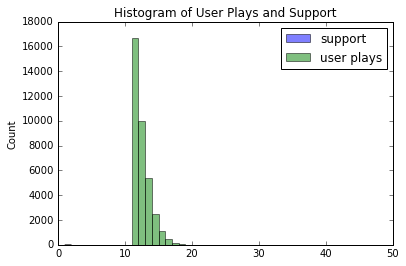

In [77]:
plt.hist(s, bins=np.arange(1,50,1), alpha=0.5, label="support");
c = smalldf.groupby('user').genre1.count()
print "User genre plays mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(1,50,1), alpha=0.5, label="user plays");
plt.legend();
plt.ylabel("Count")
plt.title("Histogram of User Plays and Support")
plt.show()

In [79]:
print smalldf.shape
smalldf=smalldf.drop_duplicates(['user','genre1'])
print smalldf.shape

(434735, 254)
(434735, 254)


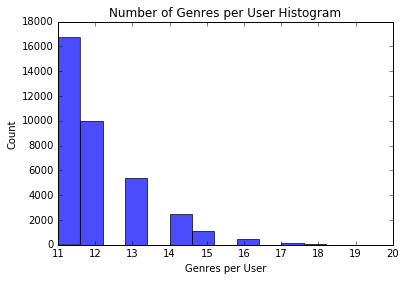

In [80]:
plt.hist(smalldf.groupby('user').count().user_genre_count,bins=15,alpha=0.7)
plt.xlabel("Genres per User")
plt.ylabel("Count")
plt.title("Number of Genres per User Histogram")
plt.show()

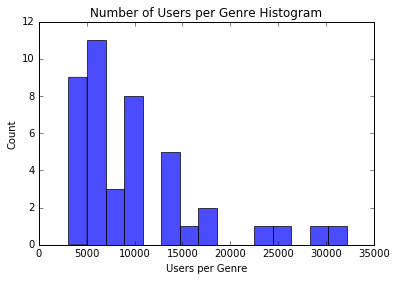

In [81]:
plt.hist(smalldf.groupby('genre1').count().genre_user_count,bins=15,alpha=0.7)
plt.xlabel("Users per Genre")
plt.ylabel("Count")
plt.title("Number of Users per Genre Histogram")
plt.show()

In [82]:
smalldf[smalldf.user_genre_count > 12].shape

(131262, 254)

In [83]:
trainlist=[]
testlist=[]
validatelist=[]
take=5
for k, v in smalldf.groupby('user'):
    if np.mean(v.user_genre_count) > 12:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(386895, 254) (28704, 254) (19136, 254)


In [84]:
# this takes a while ~10min

maskval=[e in set(validatedf.genre1).difference(set(traindf.genre1)) for e in validatedf.genre1] 
masktest=[e in set(testdf.genre1).difference(set(traindf.genre1)) for e in testdf.genre1] 
print np.sum(maskval), np.sum(masktest)

0 0


In [85]:
traindf = recompute_frame(traindf)
validatedf = recompute_frame(validatedf)
testdf = recompute_frame(testdf)
validatedf = validatedf[['user', 'genre1','plays']]
testdf = testdf[['user', 'genre1', 'plays']]
traindf.head()

,user,genre1,plays,sex,age,country,male,female,sex_missing,age_missing,...,Rwanda,Saint Kitts and Nevis,New Caledonia,Sudan,Guyana,Marshall Islands,genre_avg,genre_user_count,user_avg,user_genre_count
0,000429493d9716b66b02180d208d09b5b89fbe64,alternative rock,219.00,m,23,United States,1,0,0,0,...,0,0,0,0,0,0,258.968507,32194,314.270833,12
1,000429493d9716b66b02180d208d09b5b89fbe64,american,264.75,m,23,United States,1,0,0,0,...,0,0,0,0,0,0,255.208990,23316,314.270833,12
2,000429493d9716b66b02180d208d09b5b89fbe64,blues rock,216.00,m,23,United States,1,0,0,0,...,0,0,0,0,0,0,254.589414,10325,314.270833,12
3,000429493d9716b66b02180d208d09b5b89fbe64,british,168.00,m,23,United States,1,0,0,0,...,0,0,0,0,0,0,216.982690,24646,314.270833,12
4,000429493d9716b66b02180d208d09b5b89fbe64,canadian,328.00,m,23,United States,1,0,0,0,...,0,0,0,0,0,0,252.637899,10023,314.270833,12


In [121]:
# traindf.to_csv("train.csv")
# validatedf.to_csv("validate.csv")
# testdf.to_csv("test.csv")
# traindf = pd.read_csv("train.csv")
# validatedf = pd.read_csv("validate.csv")
# testdf = pd.read_csv("test.csv")

In [87]:
testdf.head()

,user,genre1,plays
0,000429493d9716b66b02180d208d09b5b89fbe64,indie rock,435
1,000429493d9716b66b02180d208d09b5b89fbe64,rock and indie,218
2,000710d4dff11af267edd2f70bf54e7678bdd729,indie rock,108
3,000710d4dff11af267edd2f70bf54e7678bdd729,punk,286
4,0009194b405052f1ee09a9cce78d660c47832735,punk rock,824


In [89]:
ybar = traindf.plays.mean()
ybar

253.95572725154435

In [90]:
uuids = traindf.user.unique()   #unique-user-ids
uiids = traindf.genre1.unique() #unique-item-ids

In [91]:
uuidmap = {v:k for k,v in enumerate(uuids)}#of length U
uiidmap = {v:k for k,v in enumerate(uiids)}#of length M

In [92]:
testdf.head()

,user,genre1,plays
0,000429493d9716b66b02180d208d09b5b89fbe64,indie rock,435
1,000429493d9716b66b02180d208d09b5b89fbe64,rock and indie,218
2,000710d4dff11af267edd2f70bf54e7678bdd729,indie rock,108
3,000710d4dff11af267edd2f70bf54e7678bdd729,punk,286
4,0009194b405052f1ee09a9cce78d660c47832735,punk rock,824


In [93]:
#Initialize two dictionaries
user_biases = {}
item_biases = {}

#loop through each user/item, filter by user/item and calculate mean star rating for that user/item
#then subtract average rating to obtain bias
for user in uuids:
    user_biases[user] = traindf[traindf.user == user].plays.mean() - ybar

for item in uiids:
    item_biases[item] = traindf[traindf.genre1 == item].plays.mean() - ybar

In [95]:
#calculate mean and median valuse for our two dictionaries
u_mean = np.mean(user_biases.values())
i_mean = np.mean(item_biases.values())

u_med = np.median(user_biases.values())
i_med = np.median(item_biases.values())

print "User mean is ", u_mean
print "User median is ", u_med
print "Genre mean is ", i_mean
print "Genre median is ", i_med

User mean is  -0.271620577128
User median is  -87.9102727061
Genre mean is  0.271100906302
Genre median is  -1.31782775372


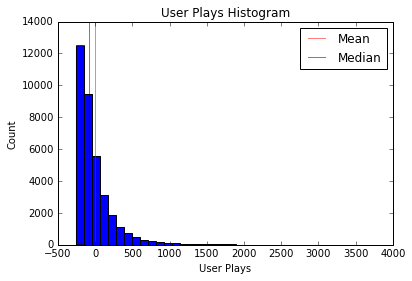

In [104]:
#plot user rating histogram with mean and median
plt.hist(user_biases.values(),alpha=1, bins=100)
plt.axvline(u_mean,alpha = .5,color="r",label = "Mean")
plt.axvline(u_med,alpha = .5,color="k",label = "Median")
plt.xlabel("User Plays")
plt.ylabel("Count")
plt.title("User Plays Histogram")
plt.xlim(-500,4000)
plt.legend()
plt.show()

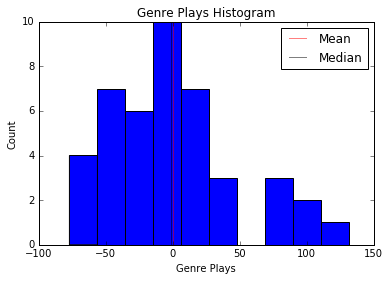

In [110]:
#plot business rating histogram with mean and median
plt.hist(item_biases.values(),alpha=1,bins = 10)
plt.axvline(i_mean,alpha = .5,color="r",label = "Mean")
plt.axvline(i_med,alpha = .5,color="k",label = "Median")
plt.xlabel("Genre Plays")
plt.ylabel("Count")
plt.title("Genre Plays Histogram")
#plt.xlim(-1.5,1.5)
plt.legend()
plt.show()

In [125]:
traindf.plays = traindf.plays.apply(lambda x: int(x))
validatedf.plays = validatedf.plays.apply(lambda x: int(x))
testdf.plays = testdf.plays.apply(lambda x: int(x))

In [136]:
for i in range(1,10):
    print i*play_max/1000.

121.283
242.566
363.849
485.132
606.415
727.698
848.981
970.264
1091.547


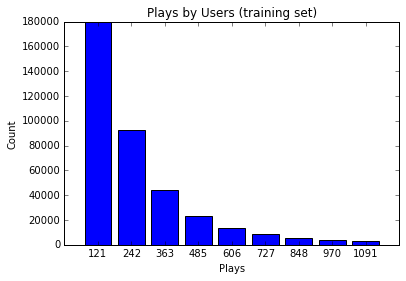

In [139]:
to_plot=[]
play_max = traindf.plays.max()
for i in range(1,10):
    condition = (traindf['plays'] > (i-1)*play_max/1000.0) & ((traindf['plays'] < i*play_max/1000.0))
    to_plot.append(traindf[condition].plays.count())
plt.bar(range(1,10),to_plot,width=0.8,align = "center")
plt.title("Plays by Users (training set)")
plt.ylabel("Count")
plt.xlabel("Plays")
plt.xticks(range(1,10), ["121","242","363","485","606","727","848","970","1091"])
plt.show()

In [140]:
train_avgs={'mean':ybar, 'users':user_biases, 'items':item_biases}

In [141]:
#loop through each review in test and validate dataframes
#compute our baseline prediction using ybar + user bias + item bias
baseline_test_predictions = []
for i in range(testdf.shape[0]):
    baseline_test_predictions.append(ybar + user_biases[testdf.iloc[i,:].user] + item_biases[testdf.iloc[i,:].genre1])

baseline_validate_predictions = []
for i in range(validatedf.shape[0]):
    baseline_validate_predictions.append(ybar + user_biases[validatedf.iloc[i,:].user] + item_biases[validatedf.iloc[i,:].genre1])

predictions={}
predictions_valid={}    
predictions["baseline"] = baseline_test_predictions
predictions_valid["baseline"] = baseline_validate_predictions

In [142]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [149]:
def compare_results(plays_actual, plays_predicted, ylow=1, yhigh=play_max/1000.0, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=plays_actual, predicted=plays_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="Means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.2, label="Predicted for %s" % model)

    if not onsame:
        ax.plot([1,10],[1,10], 'k', label="Slope 1")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.9, 10.1])
        ax.set_title("Prediction Model")
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(plays_actual, plays_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline 465.976804913


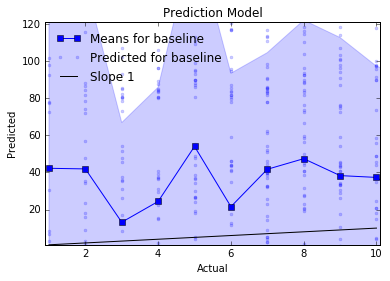

In [150]:
compare_results(testdf.plays,predictions['baseline'], model="baseline", predicteds=True);

In [151]:
#for each restaurant get the unique userids who rated it
users_for_genres = traindf.groupby('genre1').user.unique()
genres=uiids
lres=len(genres)
supports=[[[] for i in range(lres)] for i in range(lres)]
supporthistlist=[]
for i,gen1 in enumerate(genres):
    for j,gen2 in enumerate(genres):
        if  i <= j:#its symmetric
            if gen1==gen2:
                common_genres=users_for_genres[gen1]
            else:
                common_genres = set(users_for_genres[gen1]).intersection(set(users_for_genres[gen2]))
                supporthistlist.append(len(common_genres))
            supports[i][j]=common_genres
            supports[j][i]=common_genres
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 2108.64008859 1263.0


In [152]:
print len(smalldf.values)

434735


In [153]:
from scipy.stats.stats import pearsonr
"""
Given a subframe or dictionary of restaurant 1 reviews and a subframe or dictionary of restaurant 2 reviews, 
and the number of common reviewers n_common,
where the reviewers are those who have reviewed both restaurants, return 
the pearson correlation coefficient between the user average subtracted ratings.
The case for zero common reviewers is handled separately, return 0. If the correlation is
NaN if any of the individual variances are 0 (the n=1 case), return 0 instead."""

def pearson_sim(gen1_plays,gen2_plays,n_common):
    #check to see i n_common is 0 or 1
    if n_common == 0:
        return 0
    elif n_common == 1:
        return 0    
    
    #if working with list (derived from a dict) then do the following:
    elif type(gen1_plays) == type(list()):
        rho = pearsonr(gen1_plays,gen2_plays)
        return rho[0]
    
    #else if working with a df, do the following
    else:    
        X = []
        Y = []
        
        #make sure the entry isn't empty then append the bias for X
        for i in range(len(gen1_plays.index)):
            #if not rest1_reviews.iloc[i].empty:
            X.append(gen1_plays.iloc[i].plays - gen1_plays.iloc[i].user_avg)
                
        #make sure the entry isn't empty then append the bias for Y
        for j in range(len(gen2_plays.index)):   
            #if not rest2_reviews.iloc[j].empty:  
            Y.append(gen2_plays.iloc[j].plays - gen2_plays.iloc[j].user_avg)
               
        #calculate rho
        rho = pearsonr(X,Y)
        if np.isnan(rho[0]):
            return 0
        else:
            return rho[0]        
        

In [197]:
def get_genre_plays(genre, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.genre1==genre)
    plays = df[mask]
    plays = plays[plays.user.duplicated()==False]
    return plays

In [155]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

In [156]:
db = Database(uiidmap, supports)

In [162]:
print traindf.columns
for row in traindf.head(2).itertuples():
    for i in range(256):
        print i, row[i]

Index([u'Unnamed: 0', u'user', u'genre1', u'plays', u'sex', u'age', u'country',
       u'male', u'female', u'sex_missing',
       ...
       u'Rwanda', u'Saint Kitts and Nevis', u'New Caledonia', u'Sudan',
       u'Guyana', u'Marshall Islands', u'genre_avg', u'genre_user_count',
       u'user_avg', u'user_genre_count'],
      dtype='object', length=255)
0 0
1 0
2 000429493d9716b66b02180d208d09b5b89fbe64
3 alternative rock
4 219
5 m
6 23.0
7 United States
8 1
9 0
10 0
11 0
12 0
13 0.0
14 0.0
15 1.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0


In [186]:
def mapper1(row):
    return row[2], (row[3], row[4], row[254])

In [187]:
def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()

In [188]:
def reducer1(the_input):
    user, values = the_input
    ratings=[]
    for genre,plays,user_avg in values:
        ratings.append((genre,(plays, user_avg)))
    return user, ratings

In [189]:
from itertools import *
def mapper2(reduced1):
    tuples = []
    
    #get set of combinations from our input
    combinations = list(combinations_with_replacement(reduced1[1],2))
    
    #cycle through newly created combinations. check if alphabetized, then create final tuple pair as directed.
    for combo in combinations:
        if combo[0][0] > combo[1][0]:
            tuple1 = (combo[1][0],combo[0][0])
            tuple2 = (combo[1][1],combo[0][1])
        else:
            tuple1 = (combo[0][0],combo[1][0])
            tuple2 = (combo[0][1],combo[1][1])           
        
        #add tuples created
        tuples_to_add=(tuple1,tuple2)
        tuples.append(tuples_to_add)
    return tuples

In [190]:
def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()

In [191]:
def reducer2(combine2):
    #grab the IDs from the input
    genre1 = combine2[0][0]
    genre2 = combine2[0][1]
    genre1_plays = []
    genre2_plays = []
    
    #append the reviews for each restaurant
    for i in range(len(combine2[1])):
        genre1_plays.append(combine2[1][i][0][0]-combine2[1][i][0][1])
        genre2_plays.append(combine2[1][i][1][0]-combine2[1][i][0][1])
    n_common = len(combine2[1])
    
    #calculate rho
    rho = pearson_sim(genre1_plays,genre2_plays,n_common)
    return (genre1, genre2),(rho, n_common)

In [192]:
def map_reduce(tuples):

    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [193]:
tuples = traindf.itertuples()
sims = map_reduce(tuples)

In [194]:
def populate_from_mr(db, df, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.rindexmap[tpair[0]]
        i2=db.rindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [195]:
populate_from_mr(db, traindf, sims)

In [196]:
db2 = Database( uiidmap, supports)

In [213]:
def calculate_similarity(db, df, rest1, rest2, similarity_func):
    # find common reviewers
    common_users = db.supports[db.rindexmap[gen1]][db.rindexmap[gen2]]
    n_common = len(common_users)
    if gen1==gen2:
        return 1., n_common
    #get reviews
    gen1_plays = get_genre_plays(rest1, df, common_users)
    gen2_plays = get_genre_plays(rest2, df, common_users)
    sim=similarity_func(gen1_plays, gen2_plays, n_common)
    return n_common, sim

def populate_by_calculating(db, df, similarity_func):
    """
    a populator for every pair of businesses in df. takes similarity_func like
    pearson_sim as argument
    """
    items=db.rindexmap.items()
    for b1, i1 in items:
        for b2, i2 in items:
            if i1 <= i2:
                nsup, sim = calculate_similarity(db, df, b1, b2, similarity_func)
                db.database_sim[i1][i2]=sim
                db.database_sim[i2][i1]=sim
                db.database_sup[i1][i2]=nsup
                db.database_sup[i2][i1]=nsup

In [214]:
%%time
populate_by_calculating(db2, traindf, pearson_sim)

CPU times: user 2.11 ms, sys: 556 µs, total: 2.66 ms
Wall time: 2.15 ms


In [202]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [203]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the set of restaurants.
    """

    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.get(restaurant_id, other_rest_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_rest_id, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [205]:
def get_users_genres(df, user):
    dfuser=df[df.user==user]
    dfuserdedup=dfuser.drop_duplicates('genre1')
    return dict(zip(dfuserdedup.genre1.values, dfuserdedup.plays.values))

In [ ]:
"""
Function
--------
rating

Parameters
----------
set_of_restaurants: Dictionary
    The dictionary of restaurant: star-rating pairs you want to make the prediction from.
    This would be the output of a function like get_users_restaurants
train_map: Dictionary
    A dictionary with keys mean, users and items which have estimates of
    overall average or intercept, user coefficients(averages), and
    item coefficients(averages) respectively
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the imputed rating that we predict that user_id will make for restaurant_id
    
Notes
--------
If the sum of scores is 0, return the baseline estimate of the ranking.
"""
def rating(set_of_restaurants,train_map,dbase,restaurant_id,user_id,reg,k=7):
    #Baseline = mean + user bias + item bias
    Ybar_baseline = train_map["mean"] + train_map["users"][user_id] + train_map["items"][restaurant_id]
    
    #cast k as int to avoid errors down the road
    k_int = int(k)
    neighbors = knearest(restaurant_id, set_of_restaurants, dbase, k_int, reg)
    
    #initialize denominator of our prediction equation
    sim_sum_denom = 0

    for i in neighbors:
            sim_sum_denom += (1-i[1]) #take 1 - the shrunken distance to obtain similarity measure. same done below.
    
    #initialize numerator of our prediciton equation
    sim_sum_num = 0
    for j in neighbors:
            sim_sum_num += (1-j[1])*(set_of_restaurants[j[0]]-(train_map["mean"] + train_map["users"][user_id] + train_map["items"][j[0]]))
    
    if sim_sum_denom == 0:
        return Ybar_baseline
    
    else:  
        return Ybar_baseline + (sim_sum_num / sim_sum_denom)